In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from datetime import datetime
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)
pd.set_option('display.max_colwidth', None)

In [2]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [3]:
cars_df = pd.read_csv('cars_cleaned.csv')

In [4]:
cars_df.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
cars_df['DATE_SOLD'] = pd.to_datetime(cars_df['DATE_SOLD'])

In [6]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   URL                908 non-null    object        
 1   VIN                908 non-null    object        
 2   YEAR               908 non-null    int64         
 3   MILEAGE            908 non-null    object        
 4   EXT_COLOR          908 non-null    object        
 5   INT_COLOR          908 non-null    object        
 6   TRANSMISSION       908 non-null    object        
 7   BODY_STYLE         908 non-null    object        
 8   LOCATION           908 non-null    object        
 9   DATE_SOLD          908 non-null    datetime64[ns]
 10  SELLER_TYPE        908 non-null    object        
 11  NUM_PHOTOS         908 non-null    float64       
 12  SALE_PRICE         908 non-null    float64       
 13  RESULT             908 non-null    object        
 14  LIMITED   

In [7]:
cars_df['AGE_WHEN_SOLD'] = cars_df['DATE_SOLD'].dt.year - cars_df['YEAR']

In [8]:
cars_df['DATE_TO_ORDINAL'] = cars_df['DATE_SOLD'].map(datetime.toordinal)

In [9]:
cars_df = pd.get_dummies(cars_df, columns = ['TRANSMISSION_TYPE', 'BODY_STYLE', \
                                            'EXT_COLOR_CLEANED', 'SELLER_TYPE', 'RESULT', 'STATE', \
                                            'LIMITED'], drop_first = True)

In [10]:
cars_df['LOG_MILEAGE'] = np.log(cars_df['MILEAGE_CLEAN'])

In [11]:
cars_df.head()

URL                VIN  \
0       https://bringatrailer.com/listing/1999-bmw-m3-138/  WBSBG9335XEY80827   
1       https://bringatrailer.com/listing/1998-bmw-m3-109/  WBSBG9326WEY77926   
2       https://bringatrailer.com/listing/1999-bmw-m3-136/  WB5BG9334XEY83671   
3  https://bringatrailer.com/listing/1998-bmw-m3-sedan-70/  WBSCD9326WEE08819   
4       https://bringatrailer.com/listing/1995-bmw-m3-206/  WBSBF9323SEH03781   

   YEAR          MILEAGE                    EXT_COLOR  \
0  1999        66k Miles        estoril blue metallic   
1  1998       103k Miles                 alpine white   
2  1999        81k Miles  estoril blue metallic paint   
3  1998  89k Miles Shown     titanium silver metallic   
4  1995      162K Miles           brilliant red paint   

                             INT_COLOR                    TRANSMISSION  \
0  light grey nappa leather upholstery  Five-Speed Manual Transmission   
1                  black nappa leather  Five-Speed Manual Transmission   
2                  black nappa leather  Five-Speed Manual Transmission   
3              gray leather upholstery  Five-Speed Manual Transmission   
4       black nappa leather upholstery  Five-Speed Manual Transmission   

                                LOCATION  DATE_SOLD  NUM_PHOTOS  ...  \
0  Location: Fullerton, California 92833 2021-09-24       222.0  ...   
1       Location: Portland, Oregon 97209 2021-09-22       245.0  ...   
2           Location: Bend, Oregon 97701 2021-09-15       264.0  ...   
3   Location: Lake Placid, Florida 33852 2021-09-14       116.0  ...   
4        Location: Muncie, Indiana 47303 2021-09-10       215.0  ...   

   STATE_South Dakota STATE_Tennessee  STATE_Texas  STATE_Utah  \
0                   0               0            0           0   
1                   0               0            0           0   
2                   0               0            0           0   
3                   0               0            0           0   
4                   0               0            0           0   

   STATE_Virginia  STATE_Washington  STATE_Wisconsin  STATE_Wyoming  \
0               0                 0                0              0   
1               0                 0                0              0   
2               0                 0                0              0   
3               0                 0                0              0   
4               0                 0                0              0   

   LIMITED_Regular  LOG_MILEAGE  
0                1    11.097410  
1                1    11.542484  
2                1    11.302204  
3                1    11.396392  
4                1    11.995352  

[5 rows x 76 columns]

In [12]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        908 non-null    object        
 1   VIN                        908 non-null    object        
 2   YEAR                       908 non-null    int64         
 3   MILEAGE                    908 non-null    object        
 4   EXT_COLOR                  908 non-null    object        
 5   INT_COLOR                  908 non-null    object        
 6   TRANSMISSION               908 non-null    object        
 7   LOCATION                   908 non-null    object        
 8   DATE_SOLD                  908 non-null    datetime64[ns]
 9   NUM_PHOTOS                 908 non-null    float64       
 10  SALE_PRICE                 908 non-null    float64       
 11  TITLE                      908 non-null    object        
 12  ZIP     

In [14]:
g = sns.pairplot(cars_df[['SALE_PRICE', 'MILEAGE_CLEAN', 'LOG_MILEAGE', 'YEAR', 'AGE_WHEN_SOLD', 'NUM_PHOTOS', 'DATE_TO_ORDINAL']])
g.savefig('numeric_pairplot.png', facecolor = 'w');

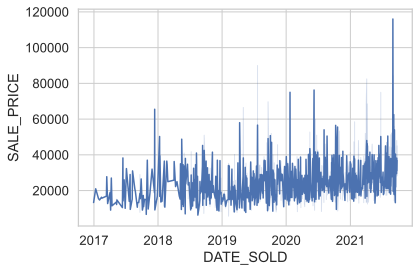

In [16]:
g = sns.lineplot(x = cars_df['DATE_SOLD'], y = cars_df['SALE_PRICE'], data = cars_df)

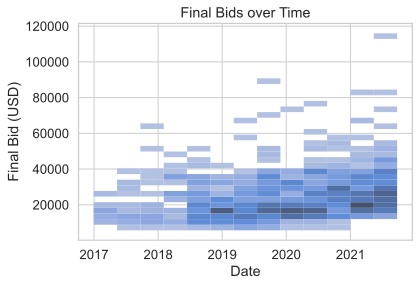

In [46]:
g = sns.histplot(x = cars_df['DATE_SOLD'], y = cars_df['SALE_PRICE']).set_title("Final Bids over Time")
plt.xlabel('Date')
plt.ylabel('Final Bid (USD)')
plt.savefig('price_vs_date.png', dpi = 150, facecolor = 'w', bbox_inches = 'tight');

In [15]:
cars_df[['SALE_PRICE', 'MILEAGE_CLEAN', 'LOG_MILEAGE', 'YEAR', 'AGE_WHEN_SOLD', 'NUM_PHOTOS', 'DATE_TO_ORDINAL']].corr()

SALE_PRICE  MILEAGE_CLEAN  LOG_MILEAGE      YEAR  \
SALE_PRICE         1.000000      -0.581524    -0.644764  0.471789   
MILEAGE_CLEAN     -0.581524       1.000000     0.873650 -0.416908   
LOG_MILEAGE       -0.644764       0.873650     1.000000 -0.385307   
YEAR               0.471789      -0.416908    -0.385307  1.000000   
AGE_WHEN_SOLD     -0.401648       0.411228     0.381132 -0.968955   
NUM_PHOTOS         0.223826      -0.039043    -0.047713 -0.035325   
DATE_TO_ORDINAL    0.285978      -0.026413    -0.020550  0.088440   

                 AGE_WHEN_SOLD  NUM_PHOTOS  DATE_TO_ORDINAL  
SALE_PRICE           -0.401648    0.223826         0.285978  
MILEAGE_CLEAN         0.411228   -0.039043        -0.026413  
LOG_MILEAGE           0.381132   -0.047713        -0.020550  
YEAR                 -0.968955   -0.035325         0.088440  
AGE_WHEN_SOLD         1.000000    0.110571         0.154181  
NUM_PHOTOS            0.110571    1.000000         0.327542  
DATE_TO_ORDINAL       0.154181    0.327542         1.000000

In [16]:
cars_df.head()

URL                VIN  \
0       https://bringatrailer.com/listing/1999-bmw-m3-138/  WBSBG9335XEY80827   
1       https://bringatrailer.com/listing/1998-bmw-m3-109/  WBSBG9326WEY77926   
2       https://bringatrailer.com/listing/1999-bmw-m3-136/  WB5BG9334XEY83671   
3  https://bringatrailer.com/listing/1998-bmw-m3-sedan-70/  WBSCD9326WEE08819   
4       https://bringatrailer.com/listing/1995-bmw-m3-206/  WBSBF9323SEH03781   

   YEAR          MILEAGE                    EXT_COLOR  \
0  1999        66k Miles        estoril blue metallic   
1  1998       103k Miles                 alpine white   
2  1999        81k Miles  estoril blue metallic paint   
3  1998  89k Miles Shown     titanium silver metallic   
4  1995      162K Miles           brilliant red paint   

                             INT_COLOR                    TRANSMISSION  \
0  light grey nappa leather upholstery  Five-Speed Manual Transmission   
1                  black nappa leather  Five-Speed Manual Transmission   
2                  black nappa leather  Five-Speed Manual Transmission   
3              gray leather upholstery  Five-Speed Manual Transmission   
4       black nappa leather upholstery  Five-Speed Manual Transmission   

                                LOCATION  DATE_SOLD  NUM_PHOTOS  ...  \
0  Location: Fullerton, California 92833 2021-09-24       222.0  ...   
1       Location: Portland, Oregon 97209 2021-09-22       245.0  ...   
2           Location: Bend, Oregon 97701 2021-09-15       264.0  ...   
3   Location: Lake Placid, Florida 33852 2021-09-14       116.0  ...   
4        Location: Muncie, Indiana 47303 2021-09-10       215.0  ...   

   STATE_South Dakota STATE_Tennessee  STATE_Texas  STATE_Utah  \
0                   0               0            0           0   
1                   0               0            0           0   
2                   0               0            0           0   
3                   0               0            0           0   
4                   0               0            0           0   

   STATE_Virginia  STATE_Washington  STATE_Wisconsin  STATE_Wyoming  \
0               0                 0                0              0   
1               0                 0                0              0   
2               0                 0                0              0   
3               0                 0                0              0   
4               0                 0                0              0   

   LIMITED_Regular  LOG_MILEAGE  
0                1    11.097410  
1                1    11.542484  
2                1    11.302204  
3                1    11.396392  
4                1    11.995352  

[5 rows x 76 columns]

In [165]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        908 non-null    object        
 1   VIN                        908 non-null    object        
 2   YEAR                       908 non-null    int64         
 3   MILEAGE                    908 non-null    object        
 4   EXT_COLOR                  908 non-null    object        
 5   INT_COLOR                  908 non-null    object        
 6   TRANSMISSION               908 non-null    object        
 7   LOCATION                   908 non-null    object        
 8   DATE_SOLD                  908 non-null    datetime64[ns]
 9   NUM_PHOTOS                 908 non-null    float64       
 10  SALE_PRICE                 908 non-null    float64       
 11  TITLE                      908 non-null    object        
 12  ZIP     

In [17]:
#tried squaring the year and auction close date based on pair plots, but there does not seem to be any impact
cars_df['YEAR_sq'] = cars_df['YEAR'] ** 2
cars_df['DATE_sq'] = cars_df['DATE_TO_ORDINAL'] ** 2

In [18]:
#tried using ratio between year and mileage as a feature, but no impact to model
cars_df['YEAR/MILEAGE'] = cars_df['YEAR'] / cars_df['MILEAGE_CLEAN']

In [19]:
# X = cars_df[['LOG_MILEAGE', 'YEAR', 'NUM_PHOTOS', 'DATE_TO_ORDINAL', 'TRANSMISSION_TYPE_Manual', 'BODY_STYLE_Hard top']]
# X = cars_df[['YEAR', 'NUM_PHOTOS', 'DATE_TO_ORDINAL', 'TRANSMISSION_TYPE_Manual', 'EXT_COLOR_CLEANED_Blue', \
#         'EXT_COLOR_CLEANED_Gray', 'EXT_COLOR_CLEANED_Green', 'EXT_COLOR_CLEANED_Orange', \
#         'EXT_COLOR_CLEANED_Red', 'EXT_COLOR_CLEANED_Silver', 'EXT_COLOR_CLEANED_Violet', 'EXT_COLOR_CLEANED_White', \
#         'EXT_COLOR_CLEANED_Yellow', 'BODY_STYLE_Hard top', 'SELLER_TYPE_private party', 'MILEAGE_CLEAN']]
# Following set of Xs works well:
X = cars_df[['YEAR', 'DATE_TO_ORDINAL', 'LOG_MILEAGE', 'BODY_STYLE_Hard top', 'TRANSMISSION_TYPE_Manual', \
            'LIMITED_Regular', 'RESULT_Sold']]
# X = cars_df[['YEAR_sq', 'DATE_sq', 'LOG_MILEAGE', 'BODY_STYLE_Hard top', 'TRANSMISSION_TYPE_Manual', \
#              'LIMITED_Regular', 'RESULT_Sold']]
y = cars_df['SALE_PRICE']

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state = 45)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state= 4)

In [22]:
lm = LinearRegression()

In [23]:
lm.fit(X_train, y_train)

LinearRegression()

In [24]:
lm.score(X_train, y_train)

0.6687783614197806

In [25]:
lm.score(X_val, y_val)

0.6493662042439762

In [26]:
for item in zip(X, lm.coef_):
    print(item)

('YEAR', 664.0240991624294)
('DATE_TO_ORDINAL', 6.620678457316359)
('LOG_MILEAGE', -9158.731157929722)
('BODY_STYLE_Hard top', 6539.001765379025)
('TRANSMISSION_TYPE_Manual', 4769.373403283248)
('LIMITED_Regular', -16953.65391972467)
('RESULT_Sold', 5741.795747227758)


In [758]:
lm.coef_

array([ 3176.42266207,  2794.42735093, -6825.64918485,  2561.83091374,
        1934.81872869, -2162.5320842 ,  2282.34580816])

In [27]:
scaler = StandardScaler()

In [30]:
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

In [32]:
lm_scores = cross_val_score(lm, X_train_val_scaled, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
lm_scores_mean = np.mean(lm_scores)
print(lm_scores)
print(lm_scores_mean)

[0.65400897 0.63910185 0.6426627  0.59605001 0.72443849]
0.6512524043768897


In [34]:
lr_model_ridge = Ridge(.5)
lr_model_ridge.fit(X_train_val_scaled, y_train_val)

Ridge(alpha=0.5)

In [35]:
ridge_scores = cross_val_score(lr_model_ridge, X_train_val_scaled, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
ridge_scores_mean = np.mean(ridge_scores)
print(ridge_scores)
print(ridge_scores_mean)

[0.65387912 0.63938439 0.64258405 0.59604839 0.7246474 ]
0.651308671065403


In [37]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [38]:
lasso_scores = cross_val_score(lasso_model, X_train_val_scaled, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
lasso_scores_mean = np.mean(lasso_scores)
print(lasso_scores)
print(lasso_scores_mean)

[0.65398045 0.63911783 0.64263808 0.59604912 0.72450222]
0.6512575415183817


In [41]:
y_val_pred_lm = lm.predict(X_val)

In [ ]:
# for one x variable only
# plt.scatter(X_val_scaled, y_val, color = 'orange', alpha = 0.5)
# plt.plot(X_val_scaled, y_val_pred, color = 'red', linewidth = 3)
# plt.xlabel('log(Mileage)')
# plt.ylabel('Final Bid (USD)')
# plt.title('Final Bid vs. log(Mileage)')
# plt.savefig('bid_vs_log_mileage.png', facecolor = 'w', bbox_inches = 'tight');

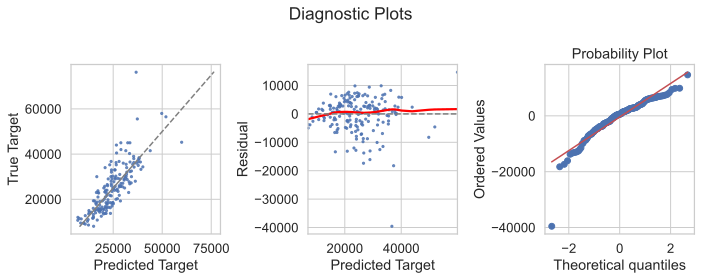

In [43]:
diagnostic_plots(y_val_pred_lm, y_val)

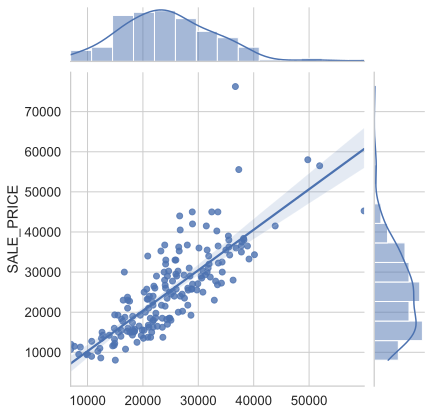

In [44]:
sns.jointplot(x = y_val_pred_lm, y = y_val, kind = 'reg');

In [45]:
print(f'Mean Squared Error: {mean_squared_error(y_val, y_val_pred_lm, squared = False)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_val_pred_lm)}')

Mean Squared Error: 6319.99663184144
Mean Absolute Error: 4516.234231827883


In [768]:
cars_df[cars_df['SALE_PRICE'] > 70000][['URL','SALE_PRICE', 'TITLE', 'YEAR', 'MILEAGE', 'EXT_COLOR', 'TRANSMISSION', 'LIMITED_Regular']]

URL  \
56     https://bringatrailer.com/listing/1995-bmw-m3-lightweight-3/   
119              https://bringatrailer.com/listing/1995-bmw-m3-146/   
143    https://bringatrailer.com/listing/1995-bmw-m3-lightweight-2/   
585               https://bringatrailer.com/listing/2004-bmw-m3-36/   
742               https://bringatrailer.com/listing/2013-bmw-m3-87/   
743  https://bringatrailer.com/listing/2012-bmw-m3-crt-lightweight/   
757               https://bringatrailer.com/listing/2012-bmw-m3-39/   

     SALE_PRICE                                                TITLE  YEAR  \
56      82500.0                              1995 BMW M3 Lightweight  1995   
119     76250.0                              1995 BMW M3 Lightweight  1995   
143     75000.0               Original-Owner 1995 BMW M3 Lightweight  1995   
585     90000.0                       16k-Mile 2003.5 BMW M3 6-Speed  2003   
742     84253.0  7,500-Mile 2013 BMW M3 Coupe Frozen Edition 6-Speed  2013   
743    116000.0           700-Mile 2012 BMW M3 CRT Lightweight Sedan  2012   
757     75000.0     11k-Mile 2012 BMW Frozen Silver Edition M3 Coupe  2012   

                MILEAGE                     EXT_COLOR  \
56           93k Miles                 alpine white w   
119     93k Miles Shown                  alpine white   
143     69k Miles Shown                  alpine white   
585  16,100 Miles Shown              laguna seca blue   
742         7,500 Miles         frozen blue metallic    
743     711 Miles Shown  frozen polar silver metallic   
757           11k Miles        frozen silver metallic   

                             TRANSMISSION  LIMITED_Regular  
56         Five-Speed Manual Transmission                0  
119           5-Speed Manual Transmission                0  
143        Five-Speed Manual Transmission                0  
585              Six-Speed Manual Gearbox                1  
742         Six-Speed Manual Transmission                0  
743      7-Speed Dual-Clutch Transmission                0  
757  Seven-Speed Dual-Clutch Transmission                0

In [331]:
#tried using PolynomialFeatures to find interactions, then Lasso to regularize
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)

In [332]:
X_val_poly = poly.transform(X_val)

In [333]:
lr_poly = LinearRegression()

In [334]:
lr_poly.fit(X_train_poly, y_train)
lr_poly.score(X_train_poly, y_train)

0.7444579144564911

In [335]:
cross_val_score(lr_poly, X_train_poly, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([  0.634491  , -10.65003552,   0.55912812,   0.75025668,
         0.69420303])

In [187]:
for item in list(zip(poly.get_feature_names(), lr_poly.coef_)):
    print(item)

('1', -745297769.5212426)
('x0', -99865.16887047657)
('x1', -17190.6888424298)
('x2', -10636.058666962976)
('x3', -1674541.9660363176)
('x4', 1347304.3279393825)
('x5', -3432364.0413639937)
('x6', 11640201.279420365)
('x0^2', 31.411426287536102)
('x0 x1', -2.4473104395199243)
('x0 x2', -0.0307383994331758)
('x0 x3', 1693.671275568798)
('x0 x4', -297.15367651974975)
('x0 x5', 754.4696438039595)
('x0 x6', -893.4714080505117)
('x1^2', -0.08585017425029307)
('x1 x2', 0.030493752157781273)
('x1 x3', 13.687772077008566)
('x1 x4', -18.574295416907844)
('x1 x5', 21.199011840284623)
('x1 x6', -180.27491284176327)
('x2^2', 0.007293190705240704)
('x2 x3', 0.035017451305776603)
('x2 x4', -1.049144827209119)
('x2 x5', -3.8739631147528257)
('x2 x6', -40.32893155158915)
('x3^2', -1674027.1829463562)
('x3 x4', -3607.784533516375)
('x3 x5', 5224.635438981324)
('x3 x6', -34486.33180928379)
('x4^2', 547.9893241309267)
('x4 x5', 166.21279531682478)
('x4 x6', 6575.2949650297305)
('x5^2', -3432440.436748878

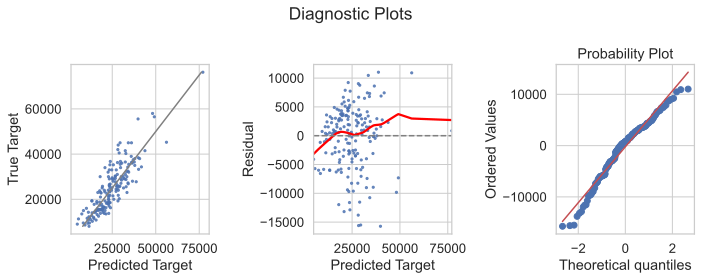

In [336]:
diagnostic_plots(lr_poly.predict(X_val_poly), y_val)

In [337]:
from sklearn.linear_model import Lasso

In [338]:
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

X_val_poly_scaled = scaler.transform(X_val_poly)

print("\t\tTrain\tTest")

alphas = np.linspace(.0001, 1000, 500)
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_poly_scaled,y_train)
    print(f"alpha={alpha}: \t{lasso.score(X_train_poly_scaled,y_train):.4f} \t{lasso.score(X_val_poly_scaled,y_val):.4f}")

		Train	Test
alpha=0.0001: 	0.7254 	0.7245
alpha=2.004107815631263: 	0.7252 	0.7237
alpha=4.008115631262525: 	0.7248 	0.7221
alpha=6.012123446893788: 	0.7242 	0.7201
alpha=8.01613126252505: 	0.7235 	0.7177
alpha=10.020139078156312: 	0.7225 	0.7149
alpha=12.024146893787576: 	0.7213 	0.7118
alpha=14.028154709418839: 	0.7199 	0.7083
alpha=16.0321625250501: 	0.7184 	0.7044
alpha=18.036170340681362: 	0.7166 	0.7002
alpha=20.040178156312624: 	0.7147 	0.6960
alpha=22.04418597194389: 	0.7128 	0.6917
alpha=24.04819378757515: 	0.7107 	0.6870
alpha=26.052201603206413: 	0.7088 	0.6830
alpha=28.05620941883768: 	0.7080 	0.6821


/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10698797197.565151, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4042292940.5632477, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232361924.6669636, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3

alpha=30.06021723446894: 	0.7072 	0.6813
alpha=32.064225050100205: 	0.7063 	0.6803
alpha=34.06823286573147: 	0.7054 	0.6794
alpha=36.07224068136273: 	0.7044 	0.6784
alpha=38.07624849699399: 	0.7033 	0.6775
alpha=40.08025631262525: 	0.7022 	0.6764
alpha=42.08426412825652: 	0.7010 	0.6754
alpha=44.08827194388778: 	0.6998 	0.6743
alpha=46.092279759519045: 	0.6985 	0.6732
alpha=48.096287575150306: 	0.6972 	0.6720
alpha=50.10029539078157: 	0.6958 	0.6709
alpha=52.10430320641283: 	0.6943 	0.6697
alpha=54.10831102204409: 	0.6933 	0.6687
alpha=56.11231883767536: 	0.6927 	0.6678
alpha=58.11632665330662: 	0.6922 	0.6669
alpha=60.120334468937884: 	0.6916 	0.6655
alpha=62.124342284569146: 	0.6910 	0.6641
alpha=64.12835010020041: 	0.6906 	0.6629
alpha=66.13235791583168: 	0.6903 	0.6619
alpha=68.13636573146293: 	0.6900 	0.6610
alpha=70.1403735470942: 	0.6897 	0.6600
alpha=72.14438136272545: 	0.6893 	0.6590


/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23553839.30773163, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23445885.669094086, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23168809.8248291, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(
/Users/manveersadhal/opt/anaconda3/lib/python3.8/

alpha=74.14838917835672: 	0.6890 	0.6580
alpha=76.15239699398798: 	0.6887 	0.6570
alpha=78.15640480961925: 	0.6883 	0.6560
alpha=80.1604126252505: 	0.6880 	0.6550
alpha=82.16442044088177: 	0.6876 	0.6540
alpha=84.16842825651304: 	0.6872 	0.6529
alpha=86.1724360721443: 	0.6869 	0.6519
alpha=88.17644388777556: 	0.6865 	0.6508
alpha=90.18045170340682: 	0.6861 	0.6498
alpha=92.18445951903809: 	0.6857 	0.6487
alpha=94.18846733466934: 	0.6853 	0.6476
alpha=96.19247515030061: 	0.6849 	0.6467
alpha=98.19648296593188: 	0.6848 	0.6468
alpha=100.20049078156313: 	0.6848 	0.6469
alpha=102.2044985971944: 	0.6847 	0.6470
alpha=104.20850641282566: 	0.6846 	0.6471
alpha=106.21251422845693: 	0.6846 	0.6472
alpha=108.21652204408818: 	0.6845 	0.6473
alpha=110.22052985971945: 	0.6844 	0.6473
alpha=112.22453767535072: 	0.6844 	0.6474
alpha=114.22854549098197: 	0.6843 	0.6475
alpha=116.23255330661324: 	0.6842 	0.6476
alpha=118.2365611222445: 	0.6842 	0.6477
alpha=120.24056893787576: 	0.6841 	0.6478
alpha=122

alpha=547.0942336673347: 	0.6716 	0.6314
alpha=549.0982414829659: 	0.6715 	0.6313
alpha=551.1022492985971: 	0.6714 	0.6312
alpha=553.1062571142285: 	0.6714 	0.6311
alpha=555.1102649298597: 	0.6713 	0.6310
alpha=557.114272745491: 	0.6712 	0.6309
alpha=559.1182805611222: 	0.6711 	0.6308
alpha=561.1222883767535: 	0.6710 	0.6307
alpha=563.1262961923848: 	0.6709 	0.6306
alpha=565.1303040080161: 	0.6708 	0.6305
alpha=567.1343118236473: 	0.6708 	0.6304
alpha=569.1383196392785: 	0.6707 	0.6303
alpha=571.1423274549098: 	0.6706 	0.6302
alpha=573.146335270541: 	0.6705 	0.6301
alpha=575.1503430861724: 	0.6704 	0.6300
alpha=577.1543509018036: 	0.6703 	0.6299
alpha=579.1583587174349: 	0.6702 	0.6298
alpha=581.1623665330661: 	0.6702 	0.6297
alpha=583.1663743486974: 	0.6701 	0.6296
alpha=585.1703821643287: 	0.6700 	0.6295
alpha=587.1743899799599: 	0.6699 	0.6294
alpha=589.1783977955912: 	0.6698 	0.6293
alpha=591.1824056112224: 	0.6697 	0.6292
alpha=593.1864134268537: 	0.6696 	0.6291
alpha=595.19042124

In [339]:
lasso=Lasso(alpha=1)
lasso.fit(X_train_poly_scaled,y_train)

/Users/manveersadhal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5223024581.172328, tolerance: 7791505.886135111
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [340]:
list(zip(poly.get_feature_names(),lasso.coef_))

[('1', 0.0),
 ('x0', -1645.4861815465722),
 ('x1', 2478.1877775433977),
 ('x2', 12657.518015598092),
 ('x3', -2515.3516279685455),
 ('x4', 8180.079206596163),
 ('x5', -2832.756942667491),
 ('x6', 918.3303904806708),
 ('x0^2', 4434.515603975372),
 ('x0 x1', 176.689653373475),
 ('x0 x2', 1185.748437684017),
 ('x0 x3', -1404.1773281646406),
 ('x0 x4', 1272.288286325954),
 ('x0 x5', 1207.0624929901633),
 ('x0 x6', 11.83691680013446),
 ('x1^2', 151.26580649011436),
 ('x1 x2', 101.80835904664838),
 ('x1 x3', -0.0),
 ('x1 x4', 547.184715706979),
 ('x1 x5', -1003.0978884894862),
 ('x1 x6', 43.739562118572),
 ('x2^2', -10296.193452129966),
 ('x2 x3', 2203.0188738551115),
 ('x2 x4', -6511.572962316515),
 ('x2 x5', -18257.758640068187),
 ('x2 x6', -13871.113073272414),
 ('x3^2', -0.0),
 ('x3 x4', 1636.2191025804877),
 ('x3 x5', 3304.5811932961337),
 ('x3 x6', 614.8807243789788),
 ('x4^2', 9251.85329940309),
 ('x4 x5', -12339.733306723187),
 ('x4 x6', -62.2997192997096),
 ('x5^2', 18019.9142111070

In [195]:
for i, item in enumerate(X):
    print(f'x{i}:{item}')

x0:YEAR
x1:NUM_PHOTOS
x2:DATE_TO_ORDINAL
x3:TRANSMISSION_TYPE_Manual
x4:LOG_MILEAGE
x5:BODY_STYLE_Hard top
x6:LIMITED_Regular


In [ ]:
#final model test

In [20]:
X = cars_df[['YEAR', 'DATE_TO_ORDINAL', 'LOG_MILEAGE', 'BODY_STYLE_Hard top', 'TRANSMISSION_TYPE_Manual', \
             'LIMITED_Regular', 'RESULT_Sold']]
y = cars_df['SALE_PRICE']

lm_final = LinearRegression()
scaler = StandardScaler()



In [21]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [22]:
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

In [613]:
# lm_final.fit(X_train_final, y_train_final)

In [614]:
# lm_final.score(X_test_final, y_test_final)

In [23]:
lm_final.fit(X_train_final_scaled, y_train_final)

LinearRegression()

In [24]:
lm_final.score(X_train_final_scaled, y_train_final)

0.6675853169158199

In [25]:
lm_final.score(X_test_final_scaled, y_test_final)

0.7634688960044955

In [26]:
for i in range(0, len(X.columns)):
    print(f'{X.columns[i]}: {lm_final.coef_[i]}')

YEAR: 2843.711968438404
DATE_TO_ORDINAL: 3027.9313610827094
LOG_MILEAGE: -6781.159399989169
BODY_STYLE_Hard top: 2421.135576422701
TRANSMISSION_TYPE_Manual: 1991.251165701252
LIMITED_Regular: -2498.8272123849147
RESULT_Sold: 2177.988624676412


In [619]:
# y_val_pred_final = lm_final.predict(X_test_final)

In [27]:
y_pred_final = lm_final.predict(X_test_final_scaled)

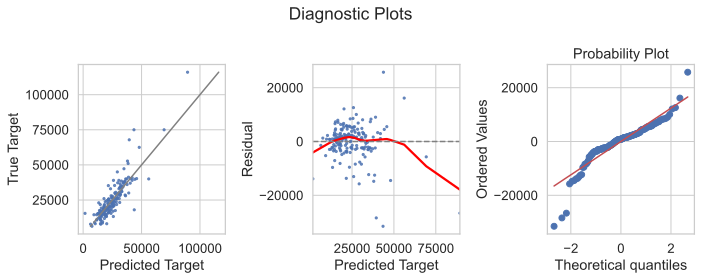

In [28]:
diagnostic_plots(y_pred_final, y_test_final)

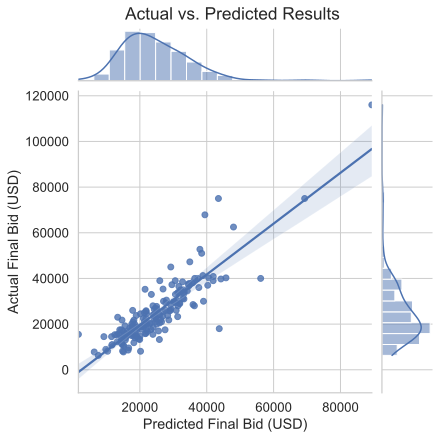

In [45]:
g = sns.jointplot(x = y_pred_final, y = y_test_final, kind = 'reg')
g.set_axis_labels('Predicted Final Bid (USD)', 'Actual Final Bid (USD)')
g.fig.suptitle('Actual vs. Predicted Results')
g.fig.subplots_adjust(top=0.93)
g.savefig('final_jointplot.png', dpi = 150, facecolor = 'w', bbox_inches = 'tight');

In [30]:
print(f'Mean Squared Error: {mean_squared_error(y_test_final, y_pred_final, squared = False)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test_final, y_pred_final)}')

Mean Squared Error: 6585.167950782711
Mean Absolute Error: 4376.86937616242


In [780]:
for item in zip(X, lm_final.coef_):
    print(item)

('YEAR', 2843.711968438404)
('DATE_TO_ORDINAL', 3027.9313610827094)
('LOG_MILEAGE', -6781.159399989169)
('BODY_STYLE_Hard top', 2421.135576422701)
('TRANSMISSION_TYPE_Manual', 1991.251165701252)
('LIMITED_Regular', -2498.8272123849147)
('RESULT_Sold', 2177.988624676412)
